# Collaborative filtering 

A distinction is often made between two forms of data collection for recommendation systems. Explicit feedback relies on the user giving  explicit signals about their preferences i.e. review ratings.  Where as, implicit feedback refers to non-explicit signals of preference e.g. user watch-time. Traditionally, recommender systems can be split into three types:

- **Collaborative filtering (CF)**: CF produces recommendations based on the knowledge of users’ attitudes towards items, that is, it uses the "wisdom of the crowd" to recommend items.  
- **Content-based  (CB)**: CB recommender systems focus on the attributes of the items to recommend other items similar to what the user likes, based on their previous actions or explicit feedback. 
- **Hybrid recommendation systems**: Hybrid methods are a combination of CB recommending and CF  methods

In many applications, content-based features are not easy to extract, and thus,
collaborative filtering approaches are preferred. Thus, we will only explore collaborative filtering methods from now on. 

CF methods typically fall into three types, memory-based, model-based and more recently deep-learning based ([Su & Khoshgoftaar, 2009](https://downloads.hindawi.com/archive/2009/421425.pdf), [He et al., 2017](https://dl.acm.org/doi/pdf/10.1145/3038912.3052569?casa_token=HwhJoWP3FJ8AAAAA:5q2ynh1Lqs2ZSuQTK3c4NQxXTQBLLtaliuX7J0LahhKfVTiteUknWAIpacxDdPJhcumF_wAS1J5gBXQ)). Neighbour-based CF and  item-based/user-based top-N recommendations are typical examples of memory-based systems that utilises user rating data to compute the similarity between users or items. As mentioned previously, common model-based approaches include  Bayesian networks, latent semantic models and markov decision processes. In this investigation, we will utilise a weighted matrix factorization approach. Later on, we will generalize the matrix factorization algorithm via a non-linear neural architecture (a softmax model). 

However, there are a number of limitations to our approaches such as the inability to model the order of interactions. For instance, Markov chain algorithms ([Rendle et al., 2010](https://dl.acm.org/doi/pdf/10.1145/1772690.1772773?casa_token=Iz8BdP3EaJwAAAAA:LokNPKaTGOZNTbQVVcBcEVfXCNaSQlGnUvwhdHUReiD003VaqTTtN-t0JCJHFUgBtG7lv_gg-zEE)) can not only encode the same information as traditional CF methods but also the order in which user's interacted with the items. Furthermore, the sparsity of the frequency matrix (*described later on*), makes computations prohibitly expensive in real-world settings, without some optimization. 



## Quick Links:
- [Setup](#setup)
- [Matrix Factorization](#matrix-factorisation)
    - [Training](#training-a-matrix-factorization-model)
        - [Vanilla Model](#vanilla-model-(non-regularized))
        - [Regularized Model](#regularized-moodel) 
    - [Evaluating Embeddings](#evaluating-the=embeddings)
- [Demo](#demo)
    
        

## Setup 
The next few code cells details the initial preparatory steps needed for the development of  our collaborative filtering models, namely importing the required libraries; scaling the ids of users and artists;constructing a indicator variable for presence of user-artist interaction;finding the most assigned tag of an artist. 



In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
import collections
from IPython import display
from matplotlib import pyplot as plt
import sklearn
import sklearn.manifold
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.logging.set_verbosity(tf.logging.ERROR)

# Add some convenience functions to Pandas DataFrame.
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.3f}'.format

# Install Altair and activate its colab renderer.
print("Installing Altair...")
!pip install git+git://github.com/altair-viz/altair.git
import altair as alt
alt.data_transformers.enable('default', max_rows=None)
alt.renderers.enable('colab')
print("Done installing Altair.")

ModuleNotFoundError: No module named 'tensorflow.python'

In [7]:
# NEEDED FOR GOOGLE COLAB
# from google.colab import auth
#from google.colab import drive
# import gspread
# from oauth2client.client import GoogleCredentials

# drive.mount('/content/drive/')
# os.chdir("/content/drive/My Drive/DCU/fouth_year/advanced_machine_learning/music-recommodation-system")

Helper functions


In [8]:
def calculate_sparsity(M):
    """
    Computes sparsity of frequency matrix
    """
    matrix_size = len((M['userID'].unique())) * len((M['artistID'].unique()))  # Number of possible interactions in the matrix
    num_plays = len(M['weight']) # Number of weights
    sparsity = (float(num_plays/matrix_size))
    return sparsity


In [9]:
def build_music_sparse_tensor(music_df):
  """
  Args:
    ratings_df: a pd.DataFrame with `userID`, `artistID` and `weight` columns.
    num_rows: an integer representing the number of rows in the frequency matrix
    num_rows: an integer representing the number of columns in the frequency matrix
  Returns:
    a tf.SparseTensor representing the feedback matrix.
  """
  indices = music_df[['userID', 'artistID']].values
  values = music_df['weight'].values
  return tf.SparseTensor(
      indices=indices,
      values=values,
      dense_shape=[num_users, num_artist])


In [10]:
def preproces_ids(music_df):
  """
  Args:
    ratings_df: a pd.DataFrame with `userID`, `artistID` and `weight` columns.
  Returns:
    a pd.DataFrame where userIDs and artistIDs now start at 1 
      and end at n and m (defined above), respectively
    two dictionary preserving the orginal ids. 
  """
  unique_user_ids_list = sorted(music_df['userID'].unique())
  print(unique_user_ids_list[0])

  unique_user_ids = dict(zip(range(0, len(unique_user_ids_list) ),unique_user_ids_list))
  unique_user_ids_switched = dict(zip(unique_user_ids_list, range(0, len(unique_user_ids) )))
  
  unique_artist_ids_list = sorted(music_df['artistID'].unique())
  unique_artist_ids = dict(zip(range(0, len(unique_artist_ids_list) ),unique_artist_ids_list))
  unique_artist_ids_switched = dict(zip(unique_artist_ids_list, range(0, len(unique_artist_ids_list) )))

  music_df['userID'] = music_df['userID'].map(unique_user_ids_switched)
  music_df['artistID'] = music_df['artistID'].map(unique_artist_ids_switched)

  return music_df, unique_user_ids, unique_artist_ids


In [11]:
def split_dataframe(df, holdout_fraction=0.1):
  """Splits a DataFrame into training and test sets.
  Args:
    df: a dataframe.
    holdout_fraction: fraction of dataframe rows to use in the test set.
  Returns:
    train: dataframe for training
    test: dataframe for testing
  """
  test = df.sample(frac=holdout_fraction, replace=False)
  train = df[~df.index.isin(test.index)]
  return train, test


Traditional recommender system development relies on explicit feedback. Many models were designed to tackle this issue as a regression problem. For instance, the input of the model would be a matrix $F_{nm}$ denoting user's (m) preference of items (n) on a scale.
In the classic movie ratings example, this preference would be users giving a 1-to-5 star rating to different movies. 

This dataset contains implicit feedback: that is, observed logs of user interactions with items, in this instance user's listening counts to artists. However, implicit feedback does not signal negativity, in the same way as a 1-star rating would. In our data, a user could listen to song of an artist a limited number of times. But that does not necessarily mean that the particular user has an aversion to that artist i.e. it could be part of a curated playlist by another user. Therefore, we decide to  construct a binary matrix, which has a value of one if the observation is observed (i.e. a listening count has been logged between an artist and a user). **Note**, a 0 is **not used** to describe unobserved artist-user interactions. This is for optimization reasons, explained below. 

In [12]:
user_artists = pd.read_csv('data/user_artists.dat', sep='\t')
user_artists['weight'] = 1
artists = pd.read_csv('data/artists.dat', sep='\t')
artists.rename({'id':'artistID'}, inplace=True, axis=1)

In [13]:
user_taggedartists = pd.read_csv(r'data/user_taggedartists-timestamps.dat', sep='\t')
user_taggedartists_years = pd.read_csv(r'data/user_taggedartists.dat', sep='\t')
tags = pd.read_csv(open('data/tags.dat', errors='replace'), sep='\t')
user_taggedartists = pd.merge(user_taggedartists, tags, on=['tagID'])

In [14]:
num_users = user_artists.userID.nunique()
num_artist = artists.artistID.nunique()
collab_filter_df = user_artists

Here, we calculate the top 10 tags by popularity. Then, we assign it to a artist, if the artist has a top 10 tag. If an artist's tags are not in the top 10, we input 'N/A'. Note, the next cell can take several mintues to compute.

In [15]:
top_10_tags = user_taggedartists['tagValue'].value_counts().index[0:10]
user_taggedartists['top10TagValue'] = None
for index, row in user_taggedartists.iterrows():
  if row['tagValue'] in top_10_tags:
    user_taggedartists.iloc[index, -1] = row['tagValue']
user_taggedartists.fillna('N/A',inplace=True)



In [16]:

artists = pd.merge(user_taggedartists, artists, on=['artistID'], how='right')[['artistID','name','top10TagValue','tagValue']].fillna('N/A')
artists.groupby(['artistID','name','top10TagValue']).agg(lambda x:x.value_counts().index[0]).reset_index()
artists = artists.drop_duplicates(subset=['artistID'])
assert artists.artistID.nunique() == num_artist



In [17]:
artists.rename({'tagValue':'mostCommonGenre'},axis=1, inplace=True)


We require two matrices or embeddings to compute a similarity measure (one for quires  and one for items), but how do we get these two embeddings?


# Matrix Factorisation 
**Figure 2**: Data flow chart
![](https://drive.google.com/uc?export=view&id=1_KTijWlqd7ff5ANGaIRg5p7xrHB72IGm)




First, we need to contsruct the feedback matrix $F \in R^{m \times  n}$, where $m$ is the number of users and $n$ is the number of artists. The goal is to two generate two lower-dimensional matrices $U_{mp}$ and $V_{np}$ ( with $p << m$ and 
$p << n$), representing latent user and artist components,  so that:
$$
 F \approx UV^\top
$$


First,we attempt to build the frequency matrix for both training and testing data.   [tf.SparseTensor](https://www.tensorflow.org/api_docs/python/tf/SparseTensor) is used
for efficient representation. Three separate arguments are used to represent a tensor, namely `indices, values, dense_shape`, where a value $A_{ij} = a$ is encoded by setting `indices[k] = [i, j]` and `values[k] = a`. The last tensor `dense_shape` is used to specify the shape of the full underlying matrix. Note, as the indices arguments represent row and columns indices, some pre-processing needs to be performed on artist and user IDs. The IDs should start from 0 and end at $m-1$ and $n-1$ for users and artists respectively. Presently, userIDs start at 2. Two dictionaries, `orginal_artist_ids`, `orginal_user_ids` will preserve the original ids for analysis purposes later on. Assertions and print statements are used to ensure the validity of the transformations. 

In [18]:
colab_filter_df, orginal_user_ids, orginal_artist_ids =  preproces_ids(collab_filter_df)

2


In [19]:
colab_filter_df.describe()

userID  artistID    weight
count 92834.000 92834.000 92834.000
mean    944.222  3235.737     1.000
std     546.751  4197.217     0.000
min       0.000     0.000     1.000
25%     470.000   430.000     1.000
50%     944.000  1237.000     1.000
75%    1416.000  4266.000     1.000
max    1891.000 17631.000     1.000

Next, we caulcate the number of unique artists, userids and sparisty of our proposed frequency matrix, before splitting into training and test subsets. Quite a sparse matrix indeed!

In [20]:
print(f'Number of unqiue users are: {collab_filter_df["userID"].nunique()}')
print(f'Number of unqiue artists are: {collab_filter_df["artistID"].nunique()}')
print(f'Sparsity of our frequency matrix: {calculate_sparsity(collab_filter_df)}')

Number of unqiue users are: 1892
Number of unqiue artists are: 17632
Sparsity of our frequency matrix: 0.002782815119924182


In [21]:
collab_filter_df.to_csv('data/test_user_artists.csv',index=False)

In [22]:
frequency_m_train, frequency_m_test = split_dataframe(colab_filter_df)
frequency_m_train_tensor  = build_music_sparse_tensor(frequency_m_train)
frequency_m_test_tensor  = build_music_sparse_tensor(frequency_m_test)


In [23]:
assert num_users  == frequency_m_train_tensor.shape.as_list()[0] 
assert num_artist == frequency_m_train_tensor.shape.as_list()[1] 
assert num_users == frequency_m_test_tensor.shape.as_list()[0] 
assert num_artist == frequency_m_test_tensor.shape.as_list()[1] 

### Training a Matrix factorization model

Per the definition above,  $UV^\top$ *approximates* $F$. The Mean Squared Error is  used to measure this approximation error. In the notation below, k is used to represent the **set** of observed listening counts, and K is the **number** of observed listening counts.

$$
\begin{align*}
\text{MSE}(F, UV^\top)
= \frac{1}{K}\sum_{(i, j) \in k}{( F_{ij} - (UV^\top)_{ij})^2} 
\end{align*}
$$

However, rather than computing the full prediction matrix, $UV^\top$ and gathering the entries in the embeddings (corresponding to the observed listening counts) , we only gather the embeddings of the observers pairs and compute their dot products. Thereby, we reduce the complexity from $O(NM)$ to $O(Kp)$ where $p$ is the embedding dimension. Stochastic gradient descent (SGD) is  used to minimize the loss (objective) function. The SDG algorithim cycles through the observed listening binary and caulates the prediction according to the following equation. 

$$
e_{ui} = F_{ui} - U_{i}V_{j}
$$

Then it updates the user and artist as embeddings as shown in the following equations. 

$$
U_{i} \leftarrow U_{i} + \alpha (e_{ui}V_{j} - \beta U_{i})
$$

$$
V_{j} \leftarrow V_{j} + \alpha (e_{ui}U_{j} - \beta V_{j})
$$

where $\alpha$  denotes the learning rate. The algorithim continues untill convergence is found. 

Other matrix factorization algorithms functions are also commonly used such as  Alternating Least Squares ([Takács and Tikk, 2012](https://dl.acm.org/doi/pdf/10.1145/2365952.2365972?casa_token=wOBbxOU-144AAAAA:4XEtNpLVu3yzAx57PPaGIgG-PBqTHuj5_QeBKPx2wXEj6N9f-k8WbFknuaT9zVbLVG0780VUBr9d)). 
A modified version of the aforementioned  function known as Weighted Alternating Least Squares (WALS) is slower than SDG but can be parallelised. For the purposes of this investigation, we are not particularly concerned with training times/latency requirements so we proceed with SDG. 

We also decide to add regularization to our model, to  avoid *overfitting*. Overfitting occurs when the model tries to fit the training dataset to hard and does not generalize well to unseen or future data. In the context of artist recommendation,  fitting the observed listening counts often emphasizes learning high similarity (between artists with many listeners), but a good embedding representation also requires learning low similarity (between artists with few listeners).

First, we define the two classes `train_matrix_norm` and `build_matrix_norm` class. The `build_matrix_norm` class  computes the necessary pre-processing steps before we train the model such as specifying the loss metric to optimise and the loss components( e.g. gravity loss for the regularized model) and the initial artist and user embeddings. `train_matrix_norm` simply trains the models and outputs figures detailing the the loss metrics and components. The methods `build_vanilla()` and `build_reg_model()` computes the necessary pre-processing steps for the non-regularized and regularized model.

In [24]:
### Training a Matrix Factorization model
class train_matrix_norm(object):
  """Simple class that represents a matrix normalisation model"""
  def __init__(self, embedding_vars, loss, metrics=None):
    """Initializes a Matrix normalisation model 
    Args:
      embedding_vars: A dictionary of tf.Variables.
      loss: A float Tensor. The loss to optimize.
      metrics: optional list of dictionaries of Tensors. The metrics in each
        dictionary will be plotted in a separate figure during training.
    """
    self._embedding_vars = embedding_vars
    self._loss = loss
    self._metrics = metrics
    self._embeddings = {k: None for k in embedding_vars}
    self._session = None


  @property
  def embeddings(self):
    """The embeddings dictionary."""
    return self._embeddings


  def train(self, num_iterations=100, learning_rate=1.0, plot_results=True,
            optimizer=tf.train.GradientDescentOptimizer):
    """Trains the model.
    Args:
      iterations: number of iterations to run.
      learning_rate: optimizer learning rate.
      plot_results: whether to plot the results at the end of training.
      optimizer: the optimizer to use. Default to SDG
    Returns:
      The metrics dictionary evaluated at the last iteration.
    """
    with self._loss.graph.as_default():
      opt = optimizer(learning_rate)
      train_op = opt.minimize(self._loss)
      local_init_op = tf.group(
          tf.variables_initializer(opt.variables()),
          tf.local_variables_initializer())
      if self._session is None:
        self._session = tf.Session()
        with self._session.as_default():
          self._session.run(tf.global_variables_initializer())
          self._session.run(tf.tables_initializer())
          tf.train.start_queue_runners()

    with self._session.as_default():
      local_init_op.run()
      iterations = []
      metrics = self._metrics or ({},)
      metrics_vals = [collections.defaultdict(list) for _ in self._metrics]

      # Train and append results.
      for i in range(num_iterations + 1):
        _, results = self._session.run((train_op, metrics))
        if (i % 10 == 0) or i == num_iterations:
          print("\r iteration %d: " % i + ", ".join(
                ["%s=%f" % (k, v) for r in results for k, v in r.items()]),
                end='')
          iterations.append(i)
          for metric_val, result in zip(metrics_vals, results):
            for k, v in result.items():
              metric_val[k].append(v)

      for k, v in self._embedding_vars.items():
        self._embeddings[k] = v.eval()

      if plot_results:
        # Plot the metrics.
        num_subplots = len(metrics)+1
        fig = plt.figure()
        fig.set_size_inches(num_subplots*10, 8)
        for i, metric_vals in enumerate(metrics_vals):
          ax = fig.add_subplot(1, num_subplots, i+1)
          for k, v in metric_vals.items():
            ax.plot(iterations, v, label=k)
          ax.set_xlim([1, num_iterations])
          ax.legend()
      return results

class build_matrix_norm():
  """Simple class that represents a matrix normalisation model"""
  def __init__(self, listens, embedding_dim=3, regularization_coeff=.1, gravity_coeff=1.,
    init_stddev=0.1):
    """Initializes a Matrix normalisation model 
    Args:
      listens: the DataFrame of artist listening counts.
      embedding_dim: The dimension of the embedding space.
      regularization_coeff: The regularization coefficient lambda.
      gravity_coeff: The gravity regularization coefficient lambda_g.
    Returns:
      A train_matrix_norm object that uses a regularized loss.
  """
    self._embedding_vars = embedding_vars
    self._loss = loss
    self._metrics = metrics
    self._embeddings = {k: None for k in embedding_vars}
    self._session = None

  def sparse_mean_square_error(sparse_listens, user_embeddings, artist_embeddings):
    """
    Args:
      sparse_listens: A SparseTensor rating matrix, of dense_shape [N, M]
      user_embeddings: A dense Tensor U of shape [N, k] where k is the embedding
        dimension, such that U_i is the embedding of user i.
      artist_embeddings: A dense Tensor V of shape [M, k] where k is the embedding
        dimension, such that V_j is the embedding of movie j.
    Returns:
      A scalar Tensor representing the MSE between the true ratings and the
        model's predictions.
    """
    predictions = tf.gather_nd(
        tf.matmul(user_embeddings, artist_embeddings, transpose_b=True),
        sparse_listens.indices)
    loss = tf.losses.mean_squared_error(sparse_listens.values, predictions)
    return loss
    
  def gravity(U, V):
    """Creates a gravity loss given two embedding matrices."""
    return 1. / (U.shape[0].value*V.shape[0].value) * tf.reduce_sum(
        tf.matmul(U, U, transpose_a=True) * tf.matmul(V, V, transpose_a=True))
  
  def build_vanilla(embedding_dim=3, init_stddev=1.):
    """performs the necessary preprocessing steps for the regularized model.  """ 
    # Initialize the embeddings using a normal distribution.
    U = tf.Variable(tf.random.normal(
      [frequency_m_train_tensor.dense_shape[0], embedding_dim], stddev=init_stddev))
    V = tf.Variable(tf.random.normal(
      [frequency_m_train_tensor.dense_shape[1], embedding_dim], stddev=init_stddev))
    
    embeddings = {"userID": U, "artistID": V}
    error_train = build_matrix_norm.sparse_mean_square_error(frequency_m_train_tensor, U, V)
    error_test = build_matrix_norm.sparse_mean_square_error(frequency_m_test_tensor, U, V)
    metrics = {
        'train_error': error_train,
        'test_error': error_test
    }
    return train_matrix_norm(embeddings, error_train, [metrics])


  def build_reg_model(embedding_dim=3, regularization_coeff=.1, gravity_coeff=1.,
  init_stddev=0.1
  ):
    """performs the necessary preprocessing steps for the regularized model.  """ 
    U = tf.Variable(tf.random.normal(
      [frequency_m_train_tensor.dense_shape[0], embedding_dim], stddev=init_stddev))
    V = tf.Variable(tf.random.normal(
      [frequency_m_train_tensor.dense_shape[1], embedding_dim], stddev=init_stddev))
  
    embeddings = {"userID": U, "artistID": V}

    error_train = build_matrix_norm.sparse_mean_square_error(frequency_m_train_tensor, U, V)
    error_test = build_matrix_norm.sparse_mean_square_error(frequency_m_test_tensor, U, V)
    gravity_loss = gravity_coeff * build_matrix_norm.gravity(U, V)
    regularization_loss = regularization_coeff * (
      tf.reduce_sum(U*U)/U.shape[0].value + tf.reduce_sum(V*V)/V.shape[0].value)
    total_loss = error_train + regularization_loss + gravity_loss
    losses = {
      'train_error_observed': error_train,
      'test_error_observed': error_test,
    }
    loss_components = {
      'observed_loss': error_train,
      'regularization_loss': regularization_loss,
      'gravity_loss': gravity_loss,
    }
    #embeddings = {"userID": U, "artistID": V}

    return train_matrix_norm(embeddings, total_loss, [losses, loss_components])

### Vanilla Model (non-regularized)

 iteration 2000: train_error=0.001319, test_error=0.148018

[{'train_error': 0.0013185361, 'test_error': 0.14801788}]

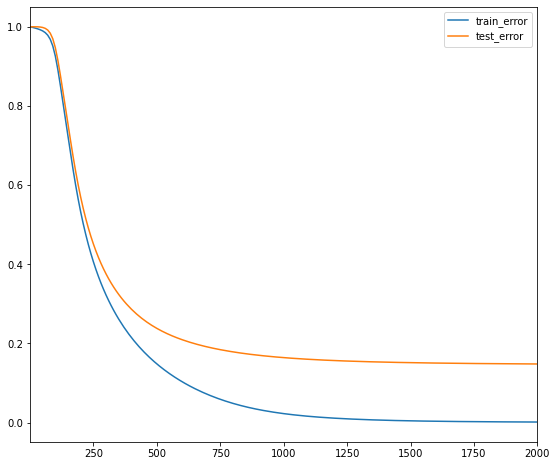

In [25]:
vanilla_model = build_matrix_norm.build_vanilla(embedding_dim=35,init_stddev=.05)
vanilla_model.train(num_iterations=2000, learning_rate=20.)

### Regularized moodel 

In [26]:
reg_model = build_matrix_norm.build_reg_model(regularization_coeff=0.1, gravity_coeff=1.0, embedding_dim=35,init_stddev=.05)

 iteration 2000: train_error_observed=0.092527, test_error_observed=0.238303, observed_loss=0.092527, regularization_loss=0.115726, gravity_loss=0.048498

[{'train_error_observed': 0.09252745, 'test_error_observed': 0.238303},
 {'observed_loss': 0.09252745,
  'regularization_loss': 0.115726285,
  'gravity_loss': 0.04849844}]

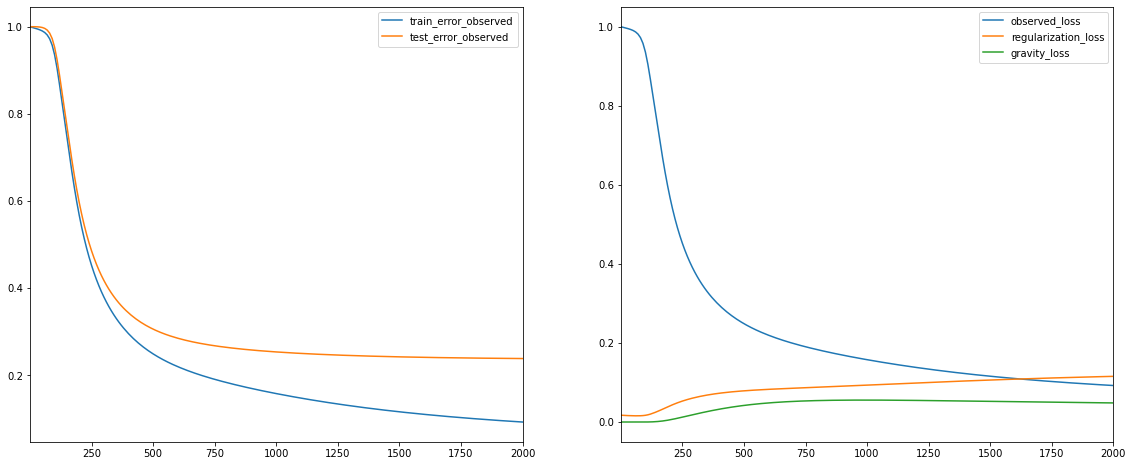

In [27]:
reg_model.train(num_iterations=2000, learning_rate=20.)

In both models, we observe a steep loss in train error and test as the model progress. Although, the regularized model has a higher MSE, both on the training and test set. It must be noted that the quality of recommendation is improved when regularization is added, which is proven when the `artist_neighbors()` function is utilized.  In addition, we observe in the end evaluation section, that the the performance of the  model is improved when regularization is added. The test error decreases similarity to the test error, although it plateaus around the 1000 epoch mark. As expected, the the additional loss generated by the regularization functions increases over epochs. We add the following regularisation terms to our model.
- Regularization of the model parameters. This is a common $\ell_2$ regularization term on the embedding matrices, given by $r(U, V) =  \frac{1}{N} \sum_i \|U_i\|^2 + \frac{1}{M}\sum_j \|V_j\|^2$.
- A global prior that pushes the prediction of any pair towards zero, called the *gravity* term. This is given by $g(U, V) = \frac{1}{MN} \sum_{i = 1}^N \sum_{j = 1}^M \langle U_i, V_j \rangle^2$

These terms modifies the "global" loss (as in, the sum of the network loss and the regularization loss) in order to drive the optimization algorithm in desired directions i.e. prevent overfitting. 

## Evaluating the embeddings
We will use two similairty meausres to inspect the robustness of our system:
- **Dot product**: score of artist j $\langle u, V_j \rangle$.
- **Cosine angle**: score of artist j $\frac{\langle u, V_j \rangle}{\|u\|\|V_j\|}$.

In [28]:
DOT = 'dot'
COSINE = 'cosine'
def compute_scores(query_embedding, item_embeddings, measure=DOT):
  """Computes the scores of the candidates given a query.
  Args:
    query_embedding: a vector of shape [k], representing the query embedding.
    item_embeddings: a matrix of shape [N, k], such that row i is the embedding
      of item i.
    measure: a string specifying the similarity measure to be used. Can be
      either DOT or COSINE.
  Returns:
    scores: a vector of shape [N], such that scores[i] is the score of item i.
  """
  u = query_embedding
  V = item_embeddings
  if measure == COSINE:
    V = V / np.linalg.norm(V, axis=1, keepdims=True)
    u = u / np.linalg.norm(u)
  scores = u.dot(V.T)
  return scores

In [29]:
def user_recommendations(model,user_id, k=15, measure=DOT, exclude_rated=False):
    scores = compute_scores(
        model.embeddings["userID"][user_id], model.embeddings["artistID"], measure)
    score_key = measure + ' score'
    df = pd.DataFrame({
        'score': list(scores),
        'name': artists.sort_values('artistID', ascending=True)['name'],
        'most assigned tag':artists.sort_values('artistID', ascending=True)['mostCommonGenre']
    })
    return df.sort_values(['score'], ascending=False).head(k)


def artist_neighbors(model, title_substring, measure=DOT, k=6):
  # Search for artist ids that match the given substring.
  inv_artist_id_mapping = {v: k for k, v in orginal_artist_ids.items()}
  ids =  artists[artists['name'].str.contains(title_substring)].artistID.values
  titles = artists[artists.artistID.isin(ids)]['name'].values
  if len(titles) == 0:
    raise ValueError("Found no artists with name %s" % title_substring)
  print("Nearest neighbors of : %s." % titles[0])
  if len(titles) > 1:
    print("[Found more than one matching artist. Other candidates: {}]".format(
        ", ".join(titles[1:])))
  artists_id_orginal = ids[0]
  asrtists_id_mapped = inv_artist_id_mapping[ids[0]]
  scores = compute_scores(
      model.embeddings["artistID"][asrtists_id_mapped], model.embeddings["artistID"],
      measure)
  score_key = measure + ' score'
  df = pd.DataFrame({
      score_key: list(scores),
      'name': artists.sort_values('artistID', ascending=True)['name'],
      'most assigned tag':artists.sort_values('artistID', ascending=True)['mostCommonGenre']
  })
  return df.sort_values([score_key], ascending=False).head(k)

Here, we find the most similar artists to the band the cure. We also include the most assigned tag associated with an artist. The reccomdations are conistent with our domain knowedge of bands similar to the cure. 



In [30]:
artist_neighbors(vanilla_model, "The Cure", DOT)

Nearest neighbors of : The Cure.


dot score             name most assigned tag
9437       0.545         The Cure          chillout
2239       0.535        Daft Punk          chillout
10365      0.534  The Cranberries       atmospheric
17472      0.530      The Killers          chillout
17278      0.529    Kings of Leon          chillout
3259       0.528         Coldplay          chillout

In [31]:
artist_neighbors(vanilla_model, "The Cure", COSINE)

Nearest neighbors of : The Cure.


cosine score         name most assigned tag
9437          1.000     The Cure          chillout
16680         0.970  The Beatles          chillout
12363         0.967         Muse          chillout
8273          0.966    Radiohead          chillout
43413         0.959  David Bowie          chillout
17472         0.959  The Killers          chillout

In [32]:
artist_neighbors(reg_model, "The Cure", DOT)

Nearest neighbors of : The Cure.


dot score         name most assigned tag
12363      3.274         Muse          chillout
16680      3.250  The Beatles          chillout
18364      3.226      Nirvana               pop
9437       3.224     The Cure          chillout
40639      3.184        Oasis               pop
3259       3.160     Coldplay          chillout

In [33]:
artist_neighbors(reg_model, "The Cure", COSINE)

Nearest neighbors of : The Cure.


cosine score                   name most assigned tag
9437          1.000               The Cure          chillout
4936          0.967           Depeche Mode          chillout
40639         0.966                  Oasis               pop
33564         0.959  The Smashing Pumpkins       atmospheric
18364         0.955                Nirvana               pop
32942         0.954             The Smiths            groove

We observe that dot product tends to recommends more popular artists such as Nirvana and The Beatles, where as Cosine Similarity recommends more obscure artists. This is likely due to the fact that the norm of the embedding in matrix factorization is often correlated with prevalence. The regularised model seems to output better reccomodations as the varation of the most assigned tag attribute is less when compared to the vanilla model. In addition, Marilyn Manson was recommended by the vanilla model in our intial run. We argue that these artists are most dis-similar! However, this observation is subject to change when you run the model, as we initialize the embedddings with a random gaussian  generator. 


In [35]:

def artist_embedding_norm(models):
  """Visualizes the norm and number of ratings of the artist embeddings.
  Args:
    model: A train_matrix_norm object.
  """
  if not isinstance(models, list):
    models = [models]
    df = pd.DataFrame({
          'name': artists.sort_values('artistID', ascending=True)['name'].values,
        'number of user-artist interactions': user_artists[['artistID','userID']].sort_values('artistID', ascending=True).groupby('artistID').count()['userID'].values,
    })
  charts = []
  brush = alt.selection_interval()
  for i, model in enumerate(models):
    norm_key = 'norm'+str(i)
    df[norm_key] = np.linalg.norm(model.embeddings["artistID"], axis=1)
    nearest = alt.selection(
        type='single', encodings=['x', 'y'], on='mouseover', nearest=True,
        empty='none')
    base = alt.Chart().mark_circle().encode(
        x='number of user-artist interactions',
        y=norm_key,
        color=alt.condition(brush, alt.value('#4c78a8'), alt.value('lightgray'))
    ).properties(
        selection=nearest).add_selection(brush)
    text = alt.Chart().mark_text(align='center', dx=5, dy=-5).encode(
        x='number of user-artist interactions', y=norm_key,
        text=alt.condition(nearest, 'name', alt.value('')))
    charts.append(alt.layer(base, text))
  return alt.hconcat(*charts, data=df)

artist_embedding_norm(reg_model)


alt.HConcatChart(...)

In [ ]:
def visualize_movie_embeddings(data, x, y):
  genre_filter = alt.selection_multi(fields=['top10TagValue'])
  genre_chart = alt.Chart().mark_bar().encode(
      x="count()",
      y=alt.Y('top10TagValue'),
      color=alt.condition(
          genre_filter,
          alt.Color("top10TagValue:N"),
          alt.value('lightgray'))
  ).properties(height=300, selection=genre_filter)
  nearest = alt.selection(
      type='single', encodings=['x', 'y'], on='mouseover', nearest=True,
      empty='none')
  base = alt.Chart().mark_circle().encode(
      x=x,
      y=y,
      color=alt.condition(genre_filter, "top10TagValue", alt.value("whitesmoke")),
  ).properties(
      width=600,
      height=600,
      selection=nearest)
  text = alt.Chart().mark_text(align='left', dx=5, dy=-5).encode(
      x=x,
      y=y,
      text=alt.condition(nearest, 'name', alt.value('')))
  return alt.hconcat(alt.layer(base, text), genre_chart, data=data)

def tsne_movie_embeddings(model):
  """Visualizes the movie embeddings, projected using t-SNE with Cosine measure.
  Args:
    model: A MFModel object.
  """
  tsne = sklearn.manifold.TSNE(
      n_components=2, perplexity=40, metric='cosine', early_exaggeration=10.0,
      init='pca', verbose=True, n_iter=400)

  print('Running t-SNE...')
  V_proj = tsne.fit_transform(model.embeddings["artistID"])
  artists.loc[:,'x'] = V_proj[:, 0]
  artists.loc[:,'y'] = V_proj[:, 1]
  return visualize_movie_embeddings(artists, 'x', 'y')

T-distributed stochastic neighbor embedding (t-SNE) is a dimensionality reduction algorithm useful for visualizing high dimensional data. We use this algorithim to visualise our embeddings of the regualrised model. Due to the large number of user submitted semantic categories, we decide to color-code the top 15 tags, with the rest being labelled as 'N/A'. Although the sea of orange, indicating'N/A', makes it difficult to interrupt these results, the regularised model seems to adequaltly cluster artists of a similar genre  in it's embeddings. 

In [ ]:
tsne_movie_embeddings(reg_model)

Running t-SNE...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 17632 samples in 0.001s...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,


[t-SNE] Computed neighbors for 17632 samples in 5.104s...
[t-SNE] Computed conditional probabilities for sample 1000 / 17632
[t-SNE] Computed conditional probabilities for sample 2000 / 17632
[t-SNE] Computed conditional probabilities for sample 3000 / 17632
[t-SNE] Computed conditional probabilities for sample 4000 / 17632
[t-SNE] Computed conditional probabilities for sample 5000 / 17632
[t-SNE] Computed conditional probabilities for sample 6000 / 17632
[t-SNE] Computed conditional probabilities for sample 7000 / 17632
[t-SNE] Computed conditional probabilities for sample 8000 / 17632
[t-SNE] Computed conditional probabilities for sample 9000 / 17632
[t-SNE] Computed conditional probabilities for sample 10000 / 17632
[t-SNE] Computed conditional probabilities for sample 11000 / 17632
[t-SNE] Computed conditional probabilities for sample 12000 / 17632
[t-SNE] Computed conditional probabilities for sample 13000 / 17632
[t-SNE] Computed conditional probabilities for sample 14000 / 17632

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.348160
[t-SNE] KL divergence after 400 iterations: 2.774187


alt.HConcatChart(...)

In [ ]:
def m_embedding_norm(models):
  """Visualizes the norm and number of ratings of the movie embeddings.
  Args:
    model: A MFModel object.
  """
  if not isinstance(models, list):
    models = [models]
    df = pd.DataFrame({
          'title': artists.sort_values('artistID', ascending=True)['name'].values,
        'num_ratings': user_artists[['artistID','userID']].sort_values('artistID', ascending=True).groupby('artistID').count()['userID'].values,
    })
  charts = []
  brush = alt.selection_interval()
  for i, model in enumerate(models):
    norm_key = 'norm'+str(i)
    df[norm_key] = np.linalg.norm(model.embeddings["artistID"], axis=1)
    nearest = alt.selection(
        type='single', encodings=['x', 'y'], on='mouseover', nearest=True,
        empty='none')
    base = alt.Chart().mark_circle().encode(
        x='num_ratings',
        y=norm_key,
        color=alt.condition(brush, alt.value('#4c78a8'), alt.value('lightgray'))
    ).properties(
        selection=nearest).add_selection(brush)
    text = alt.Chart().mark_text(align='center', dx=5, dy=-5).encode(
        x='num_ratings', y=norm_key,
        text=alt.condition(nearest, 'title', alt.value('')))
    charts.append(alt.layer(base, text))
  return alt.hconcat(*charts, data=df)


 ## Demo

You can find the most similar artist to a specified artist (that is contained in Last.FM) using the `artist_neighbours()` function. Similarily, you can find the top 10 recommendations of a particular userID [0 to 1891] using the `user_recommendations()` function. The first argument specifies the desired model, second argument the userID and third the top-k recommendations. Fourth argument represents the similarity measure, either DOT or COSINE (default = DOT, not a string). 

In [ ]:
user_recommendations(reg_model, 234, 10, COSINE)

score                                name most assigned tag
126490  0.913                     Street Bulldogs               N/A
126582  0.899                           Validuaté               N/A
126539  0.895               Menstruação Anarquika               N/A
126400  0.889                       The Vibrators              punk
126491  0.887  Bandas Gaúchas -  www.DownsMtv.com               N/A
121134  0.883                            7Seconds               80s
126536  0.878                              S.O.D.      thrash metal
126404  0.840                     Cachorro Grande              rock
126540  0.831                       The Exploited                uk
126492  0.826                    Pata de Elefante              rock

To further demonstrate the robustness of the system and measure the serendipity of our model, we incorporate the top artists  that we listen to on Spotify (i.e. an unknown user). **Note**, these artists have to also be in the Last.FM dataset. The recommendation system should output similar artists based on it's artist embeddings.  The *Spotipy* library is used to interact with Spotify's API. The similarity measure used is the Dot product. Due to the short lived nature of the spotify token and the fact you have to sign into a pop-up to retrieve the authentication token, we simply list our top 5 artists manually. If we did not, jupyter book will stall when attempting to build as it is waiting for our response.  However, we  provide the code used to retrieve the short-lived token for verification purposes.

In [ ]:
"""
import spotipy
from spotipy.oauth2 import SpotifyOAuth
client_id = <insert_your_client_id>
client_secret = <insert your client secret>
redirect_url = '<insert your redirect uri>
scope = "user-top-read user-read-playback-state streaming ugc-image-upload playlist-modify-public"

authenticate_manager = spotipy.oauth2.SpotifyOAuth(client_id = client_id,client_secret = client_secret,redirect_uri =redirect_url,scope =scope,show_dialog = True)
sp = spotipy.Spotify(auth_manager=authenticate_manager)

artists_long = sp.current_user_top_artists(limit=5, time_range="long_term")
"""
top_5_artists =[
                 'Coldplay',
                 'Paramore',
                 'Arctic Monkeys',
                 'Lily Allen',
                 'Miley Cyrus'
]
spotify_reccomdations_df = pd.DataFrame()
for artist in top_5_artists:
  similar_artist_df = artist_neighbors(reg_model, artist)[['name','dot score']]
  spotify_reccomdations_df = pd.concat([spotify_reccomdations_df, similar_artist_df])
spotify_reccomdations_df.sort_values('dot score', ascending=False).head(10)


Nearest neighbors of : Coldplay.
[Found more than one matching artist. Other candidates: Jay-Z & Coldplay, Coldplay/U2]
Nearest neighbors of : Paramore.
[Found more than one matching artist. Other candidates: Paramore攀]
Nearest neighbors of : Arctic Monkeys.
[Found more than one matching artist. Other candidates: Arctic Monkeys vs The Killers]
Nearest neighbors of : Lily Allen.
Nearest neighbors of : Miley Cyrus.
[Found more than one matching artist. Other candidates: Miley Cyrus攀, Demi Lovato Ft. Miley Cyrus Ft. Selena Gomez Ft. Jonas Brothers, Miley Cyrus and Billy Ray Cyrus, Miley Cyrus and John Travolta, Hannah Montana and Miley Cyrus]


name  dot score
3259        Coldplay      3.663
12363           Muse      3.573
17832      Green Day      3.534
37842       Paramore      3.514
17278  Kings of Leon      3.512
30355    Linkin Park      3.508
17472    The Killers      3.505
24447     Lily Allen      3.458
30355    Linkin Park      3.456
6543       Lady Gaga      3.443

We believe these recommodations are good as when our model was given an artist in the top five, it actually recommended **other** artits in the top five.

## Evaluation Code

This is the code needed to produce the in-depth model comparison. As we decided to use different notebooks for different models, the results of this code will be combined and explained later in the book. 

In [ ]:
## create holdout test set for each user (15 items)
user_artists = pd.read_csv('data/user_artists.dat', sep='\t')
user_ids = []
holdout_artits = []
for user_id in user_artists.userID.unique():
  top_15_artists = user_artists[user_artists.userID == user_id].sort_values(by='weight').head(15).artistID.tolist()
  if len(top_15_artists) == 15:
    holdout_artits.append(top_15_artists)
    user_ids.append(user_id)
holdout_df = pd.DataFrame(data={'userID':user_ids,'holdout_artists':holdout_artits})

holdout_df.to_csv('data/evaluation/test-set.csv',index=False)

In [ ]:
## Finding the models vanilla, regualrised predection for each user. 
def get_top_15_model_predictions(model, measure):
  """Computes the top 15 predictions for a given model
  Args:
    model: the name of the model
    measure: a string specifying the similarity measure to be used. Can be
      either DOT or COSINE.
  Returns:
    predicted_df a dataframe containing userIDs, their top 15 artists by the model, and the correspnding scores.
  """
  artist_name_id_dict = dict(zip(artists['name'], artists['artistID']))
  user_ids = []
  predicted_artists = []
  scores_list = []
  for new_user_id, orginal_user_id in orginal_user_ids.items():
    top_15_names = user_recommendations(model, new_user_id, k=15,measure=measure )['name'].values
    top_15_scores = user_recommendations(model, new_user_id, k=15, measure=measure )['score'].values.tolist()
    artist_ids = []
    for name in top_15_names:
      artist_ids.append(artist_name_id_dict[name])
    predicted_artists.append(artist_ids)
    user_ids.append(orginal_user_id)
    scores_list.append(top_15_scores)
  predicted_df = pd.DataFrame(data={'userID':user_ids,'predictions_artists':predicted_artists, 'score':scores_list })
  return predicted_df

In [ ]:
# save the recommended artits into dfs and save them to data/evaluation folder
vanilla_dot_pred= get_top_15_model_predictions(vanilla_model, measure=DOT)
vanilla_cos_pred = get_top_15_model_predictions(vanilla_model, measure=COSINE)
reg_dot_pred= get_top_15_model_predictions(reg_model, measure=DOT)
reg_cos_pred = get_top_15_model_predictions(reg_model, measure=COSINE)

vanilla_dot_pred.to_csv('data/evaluation/vannila_dot_pred.csv',index=False)
vanilla_cos_pred.to_csv('data/evaluation/vanila_cos_pred.csv',index=False)
reg_dot_pred.to_csv('data/evaluation/reg_dot_pred.csv',index=False)
reg_cos_pred.to_csv('data/evaluation/reg_cos_pred.csv',index=False)
